# Task 1 - Alkemy
_Lorenzo Antolini, Enrico Grandi, Simone Lu, Enrico Romano_ 

In [7]:
import pandas as pd
import numpy as np
import time
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import matplotlib.ticker as ticker
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
import networkx as nx
from matplotlib.pyplot import figure
import plotly.express as px

First of all, we import the datasets. In this case, only prices_competitor and product_catalog is necessary.

In [8]:
df_pc = pd.read_csv('prices_competitor.csv')
prod_cat = pd.read_csv('product_catalog.csv')


Then, is fundamental to merge the datasets in order to have all the information necessary for the execution of the task.

In [9]:
#df_pc[(df_pc['price']== 0)]  #rimuovere questi valori
df_merged = pd.merge(df_pc, prod_cat, how='left', on = ['product_id'])


In [10]:
df_merged_24 = df_merged.copy()

In [11]:
df_merged_24.head()

comp_date  seller_id  product_id  price  coded_cat1  coded_cat2  \
0  2021-01-01         23      110064  27990        1676        2193   
1  2021-01-01         24      110064  27990        1676        2193   
2  2021-01-01         26      110064  27990        1676        2193   
3  2021-01-01         41      110064  27490        1676        2193   
4  2021-01-01         48      110064  27990        1676        2193   

   coded_cat3  coded_brand  coded_name  
0        2891          522        2662  
1        2891          522        2662  
2        2891          522        2662  
3        2891          522        2662  
4        2891          522        2662

#create new columns for day month and year 
df_merged_24['day'] = df_merged_24['comp_date'].dt.day
df_merged_24['month'] = df_merged_24['comp_date'].dt.month
df_merged_24['year'] = df_merged_24['comp_date'].dt.year

At this point, we filtered the dataset in order to consider <b> only </b> the product sold by _our client_.

In [12]:
#filter by its products 
df_merged_24 = df_merged_24[df_merged_24['seller_id'] == 24]

products_24 = set(df_merged_24['product_id'])

df_merged_24 = df_merged[df_merged['product_id'].isin(products_24)]

#df_merged_final = df_merged_24.copy()

In [13]:
date_conversion = pd.to_datetime(df_merged_24['comp_date'], format='%Y-%m-%d')
df_merged_24['comp_date'] = date_conversion

Moreover, we created five different intervals. This is fundamental to have a more precise picture of the situation. The intervals are:
- first quarter : from January to March
- second quarter: from April to June
- third quarter : from July to September
- fourth quarter : from October to December
- black friday : November 2021

In [14]:
df_merged_24['quarter'] = df_merged_24['comp_date'].dt.quarter

q1 = df_merged_24[(df_merged_24['quarter']==1)]
q2 = df_merged_24[(df_merged_24['quarter']==2)]
q3 = df_merged_24[(df_merged_24['quarter']==3)]
q4 = df_merged_24[(df_merged_24['quarter']==4)]

black_friday = df_merged_24[(df_merged_24["comp_date"]>="2021-11-01") & (df_merged_24['comp_date']<="2021-11-30")]


In [15]:
black_friday

comp_date  seller_id  product_id  price  coded_cat1  coded_cat2  \
7195832 2021-11-01         24      110064  30990        1676        2193   
7195833 2021-11-01         26      110064  30990        1676        2193   
7195834 2021-11-01         41      110064  27042        1676        2193   
7195835 2021-11-01         41      110064  27312        1676        2193   
7195836 2021-11-01         48      110064  30990        1676        2193   
...            ...        ...         ...    ...         ...         ...   
7864869 2021-11-30         26      183535    999        1776        1306   
7864870 2021-11-30         48      183535    899        1776        1306   
7864871 2021-11-30         24      183539    699        1776        1306   
7864872 2021-11-30         26      183539   1100        1776        1306   
7864873 2021-11-30         48      183539    999        1776        1306   

         coded_cat3  coded_brand  coded_name  quarter  
7195832        2891          522        2662        4  
7195833        2891          522        2662        4  
7195834        2891          522        2662        4  
7195835        2891          522        2662        4  
7195836        2891          522        2662        4  
...             ...          ...         ...      ...  
7864869        1306          375        2820        4  
7864870        1306          375        2820        4  
7864871        1306          375        2822        4  
7864872        1306          375        2822        4  
7864873        1306          375        2822        4  

[668875 rows x 10 columns]

In [16]:
black_friday.groupby(["seller_id","comp_date"]).mean().reset_index()

seller_id  comp_date     product_id         price   coded_cat1  \
0           23 2021-11-01  139466.296625  22727.182060  1641.517762   
1           23 2021-11-02  139248.647593  22498.555858  1647.923706   
2           23 2021-11-03  139407.016071  22430.965179  1643.099107   
3           23 2021-11-04  139266.435294  22540.149321  1648.912217   
4           23 2021-11-05  139509.492471  22980.504872  1640.021258   
..         ...        ...            ...           ...          ...   
257        490 2021-11-26  139946.322082  16182.379044  1822.353024   
258        490 2021-11-27  139967.622159  16075.485795  1816.009233   
259        490 2021-11-28  139761.814522  15658.168943  1811.392523   
260        490 2021-11-29  139921.600952  15212.836166  1792.300476   
261        490 2021-11-30  139929.264433  15995.618674  1804.793300   

      coded_cat2   coded_cat3  coded_brand   coded_name  quarter  
0    1594.420959  1559.219361   446.613677  2513.237123      4.0  
1    1599.111717  1569.159855   446.884650  2512.816530      4.0  
2    1595.597321  1562.932143   447.272321  2516.638393      4.0  
3    1598.740271  1568.714932   447.955656  2515.045249      4.0  
4    1591.511957  1556.675819   447.113375  2513.309123      4.0  
..           ...          ...          ...          ...      ...  
257  1552.817159  1614.281294   454.498594  2487.893108      4.0  
258  1546.571733  1607.070312   454.617898  2481.796875      4.0  
259  1539.269590  1598.296190   454.292595  2478.703810      4.0  
260  1530.118287  1597.862678   457.388171  2483.915704      4.0  
261  1546.268710  1609.552388   453.703493  2484.875267      4.0  

[262 rows x 10 columns]

In [17]:
df_merged_24

comp_date  seller_id  product_id  price  coded_cat1  coded_cat2  \
0       2021-01-01         23      110064  27990        1676        2193   
1       2021-01-01         24      110064  27990        1676        2193   
2       2021-01-01         26      110064  27990        1676        2193   
3       2021-01-01         41      110064  27490        1676        2193   
4       2021-01-01         48      110064  27990        1676        2193   
...            ...        ...         ...    ...         ...         ...   
8473029 2021-12-31         24      184523  62990        1163         821   
8473030 2021-12-31         26      184523  62990        1163         821   
8473031 2021-12-31         24      163535  19990        1354        1600   
8473032 2021-12-31         24      172307  14649        2259        2015   
8473033 2021-12-31         26      172307  12207        2259        2015   

         coded_cat3  coded_brand  coded_name  quarter  
0              2891          522        2662        1  
1              2891          522        2662        1  
2              2891          522        2662        1  
3              2891          522        2662        1  
4              2891          522        2662        1  
...             ...          ...         ...      ...  
8473029         624          152        1293        4  
8473030         624          152        1293        4  
8473031        1065          438        1762        4  
8473032         493          364        1528        4  
8473033         493          364        1528        4  

[8470508 rows x 10 columns]

# Which are the top sold 10 products ?
We investigate about the top 10 products, in order to understand who are leaders and followers for these specific products

In [18]:
df_sales_data = pd.read_csv("sales_data.csv")
df_sales_data

sale_date  product_id  quantity  sales_price_tax  regular_price_tax  \
0       2021-01-02      109751         1           2499.0             2777.0   
1       2021-01-02      110853         1           3990.0             8322.0   
2       2021-01-02      131410         1           2288.0             3767.0   
3       2021-01-02      134294         1           4990.0             6666.0   
4       2021-01-02      134298         1           5990.0             7777.0   
...            ...         ...       ...              ...                ...   
119120  2021-12-31      184595         2           3290.0             4433.0   
119121  2021-12-31      184647         1           1990.0             2878.0   
119122  2021-12-31      184749         1           4990.0             5544.0   
119123  2021-12-31      184809         1           2590.0             2878.0   
119124  2021-12-31      184860         3          29990.0            38878.0   

        sales_price  regular_price  purchase_price  
0            2082.0      2313.8917       1499.4000  
1            3325.0      6935.1852       2833.7000  
2            1907.0      3138.8889       1860.0000  
3            4158.0      5554.6296       3599.4024  
4            4992.0      6480.5583       4199.4000  
...             ...            ...             ...  
119120       2742.0      3694.4444       2474.2500  
119121       1658.0      2398.1481       1638.0000  
119122       4158.0      4620.3704       3600.0000  
119123       2158.0      2398.1481       1650.0000  
119124      24992.0     32398.1500      22800.0001  

[119125 rows x 8 columns]

In [19]:
df_top10 = df_sales_data.groupby('product_id').count().sort_values(by='sale_date', ascending = False)[0:10].reset_index()
top_10 = df_top10['product_id']
top_10.to_frame()

product_id
0      157318
1      107645
2      157317
3      103851
4      125506
5      128772
6      132284
7      112377
8      157316
9      134358

In [20]:
#139038

param= {
    "price":"mean",
    "coded_cat1":"first",
    "coded_cat2":"first",
    "coded_cat3":"first",
    "coded_brand":"first",
    "coded_name":"first",
    "quarter":"first",
}

df_final = df_merged_24.groupby(["comp_date","seller_id","product_id"]).agg(param).reset_index()
 


# Understand price relationship

In [21]:
#top sold products
top_10

0    157318
1    107645
2    157317
3    103851
4    125506
5    128772
6    132284
7    112377
8    157316
9    134358
Name: product_id, dtype: int64

With the little code below, we can choose which product analyze and in which period.

In [22]:
product = 107645 #scegli il prodotto
period = [4]#seleziona il trimestre
blackfriday = [0] #0 per tutti i mesi, 1 per il bf

In [23]:
df_final["BLACKFRIDAY"] = [0 if x != 11 else 1 for x in df_final['comp_date'].dt.month]

df_final_product = df_final[df_final.product_id == product].reset_index(drop=True)

df_final_product = df_final_product[df_final_product["quarter"].isin(period)]

df_final_product = df_final_product[df_final_product["BLACKFRIDAY"].isin(blackfriday)]

df_final_product = df_final_product.pivot(index="comp_date",columns="seller_id", values="price")

df_final_product

seller_id      23      24      26      41      48      180     188     407  \
comp_date                                                                    
2021-10-01  1999.0  3990.0  3990.0  1874.0  3990.0  1899.0  1990.0  1691.0   
2021-10-02  1999.0     NaN     NaN     NaN     NaN     NaN  1990.0  1691.0   
2021-10-03  1999.0     NaN     NaN     NaN     NaN     NaN  1990.0  1691.0   
2021-10-04  1999.0  3990.0  3990.0  1816.0  3990.0  1899.0  1990.0  1691.0   
2021-10-05  1999.0  3990.0  3990.0  1816.0  3990.0  1899.0  1990.0  1691.0   
...            ...     ...     ...     ...     ...     ...     ...     ...   
2021-12-27     NaN  1990.0  1990.0  2144.0  1990.0     NaN     NaN  1749.0   
2021-12-28     NaN  1990.0  1990.0  2027.0  1990.0     NaN     NaN  1749.0   
2021-12-29     NaN  1990.0  1990.0  1919.5  1990.0     NaN     NaN  1699.0   
2021-12-30     NaN  1990.0  1990.0  1938.5  1990.0     NaN     NaN  1699.0   
2021-12-31     NaN  1990.0  1990.0  1957.5  1990.0     NaN     NaN  1699.0   

seller_id      490  
comp_date           
2021-10-01  1990.0  
2021-10-02  1990.0  
2021-10-03  1990.0  
2021-10-04  1791.0  
2021-10-05  1592.0  
...            ...  
2021-12-27  1990.0  
2021-12-28  1990.0  
2021-12-29  1990.0  
2021-12-30  1990.0  
2021-12-31  2090.0  

[62 rows x 9 columns]

In [24]:
df_final_product = df_final_product.fillna(0)
df_final_product = df_final_product
df_final_product_shift = df_final_product.shift(1).dropna(how='any')
df_final_product = df_final_product[1:]
df_final_product_shift.head()

seller_id      23      24      26      41      48      180     188     407  \
comp_date                                                                    
2021-10-02  1999.0  3990.0  3990.0  1874.0  3990.0  1899.0  1990.0  1691.0   
2021-10-03  1999.0     0.0     0.0     0.0     0.0     0.0  1990.0  1691.0   
2021-10-04  1999.0     0.0     0.0     0.0     0.0     0.0  1990.0  1691.0   
2021-10-05  1999.0  3990.0  3990.0  1816.0  3990.0  1899.0  1990.0  1691.0   
2021-10-06  1999.0  3990.0  3990.0  1816.0  3990.0  1899.0  1990.0  1691.0   

seller_id      490  
comp_date           
2021-10-02  1990.0  
2021-10-03  1990.0  
2021-10-04  1990.0  
2021-10-05  1791.0  
2021-10-06  1592.0

In [25]:
my_list = []
Leader = []
Follower = []
Cointegration = []
Beta = []
for i in df_final_product_shift.columns:
    for j in df_final_product_shift.columns:
        if (i!=j and df_final_product[i].corr(df_final_product_shift[j])):
            Leader.append(j)
            Follower.append(i)
            my_list.append(df_final_product[i].corr(df_final_product_shift[j]))
            Cointegration.append(coint(df_final_product_shift[j], df_final_product[i])[1] )
            Beta.append(np.linalg.lstsq(df_final_product[i].values[:,np.newaxis], df_final_product[j].values, rcond=None)[0][0])
 
 
 
output = pd.DataFrame({'Leader':Leader, 'Follower':Follower,
                       'Value':my_list, 'Cointegration':Cointegration,'Beta':Beta})
 
#output = output.loc[output.Cointegration<0.01]

In [26]:
sample = output.sort_values(by="Value", ascending=False)
sample

Leader  Follower     Value  Cointegration      Beta
45     188       180  0.910975   5.343351e-08  1.037529
53     180       188  0.900062   6.058932e-05  0.897606
48      23       188  0.564521   5.490387e-01  0.443084
5      188        23  0.520922   8.719074e-01  0.995498
40      23       180  0.436044   2.295229e-01  0.413545
..     ...       ...       ...            ...       ...
24      23        41 -0.564140   3.350571e-01  0.165383
61     180       407 -0.589248   1.601268e-01  0.492198
62     188       407 -0.662871   3.858298e-01  0.547122
46     407       180 -0.756408   1.037815e-02  0.894296
54     407       188 -0.807246   3.894777e-02  0.860024

[72 rows x 5 columns]

Network graph, give us an interesting tool to understand the relationship between sellers. Moreover, we can notice some insight that need to be confirmed with further analysis

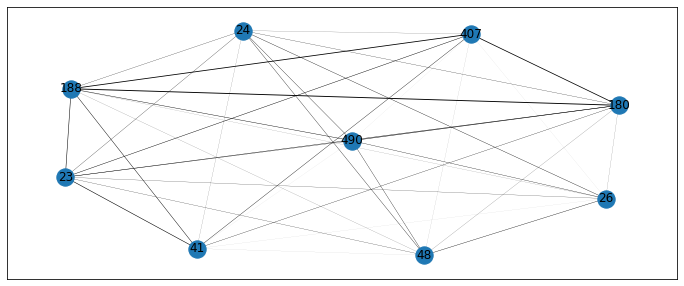

In [27]:
G = nx.from_pandas_edgelist(sample,'Leader','Follower', edge_attr='Value')

durations = [i['Value'] for i in dict(G.edges).values()]
labels = [i for i in dict(G.nodes).keys()]
labels = {i:i for i in dict(G.nodes).keys()}

fig, ax = plt.subplots(figsize=(12,5))
pos = nx.spring_layout(G)

nx.draw_networkx_nodes(G, pos, ax = ax, label=True)

nx.draw_networkx_edges(G, pos, width = durations, ax=ax)
_ = nx.draw_networkx_labels(G, pos, labels, ax=ax)

Time series representation shows us the historic prices variation for a specific product, in a determined interval, for each seller. 

In [28]:
df_graph = df_final[df_final["seller_id"].isin(sample["Leader"])]
df_graph = df_graph[(df_graph['quarter'].isin(period))]
df_graph = df_graph[(df_graph['BLACKFRIDAY'].isin(blackfriday))]

fig = px.line(df_graph[df_graph["product_id"]==product], x="comp_date", y='price',
              title=('Time series for product ' + str(product)+ ' in quarter '+ str(period) ),line_group="seller_id",color="seller_id")
fig.update_xaxes(
    dtick="M1",
    tickformat="%d\n%b\n%Y")
fig.show()

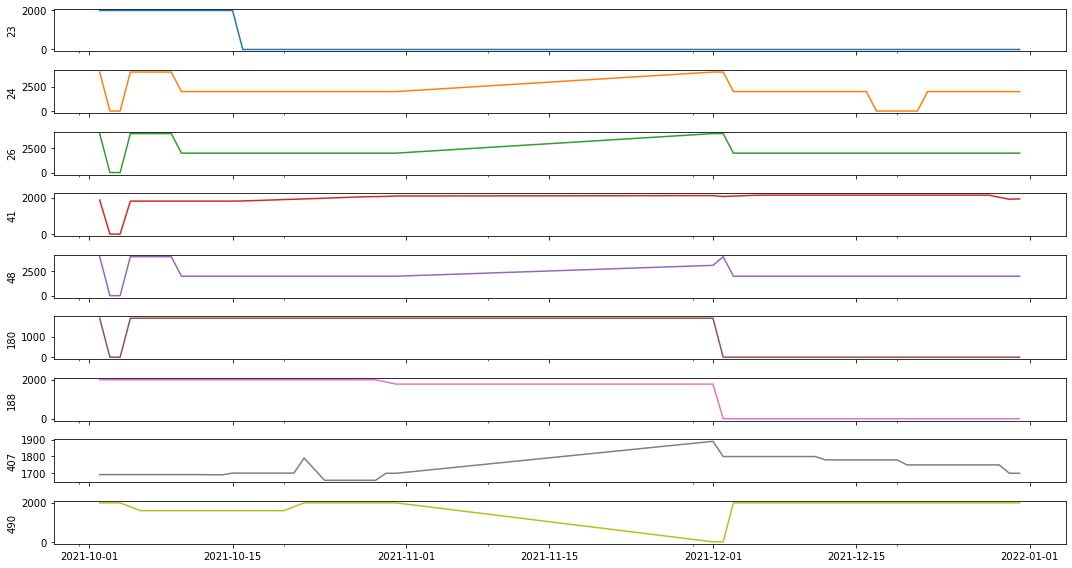

In [46]:
fig,ax = plt.subplots(len(df_final_product_shift.columns), figsize=(15,8), sharex=True)

plot_cols = df_final_product_shift.columns

df_final_product_shift[plot_cols].plot(subplots=True, legend=False, ax=ax)

for a in range(len(ax)): 
    ax[a].set_ylabel(plot_cols[a])
ax[-1].set_xlabel('')
plt.tight_layout()
plt.show()

http://www.scholarpedia.org/article/Granger_causality
https://www.analyticsvidhya.com/blog/2021/08/granger-causality-in-time-series-explained-using-chicken-and-egg-problem/
https://www.statology.org/granger-causality-test-in-python/

In order to verify our hypotesis, we perfom the Granger Causality test that help us to confirm or reject thesis about leaders, followers and usage of automated prices systems. 

In [37]:
from statsmodels.tsa.stattools  import   grangercausalitytests
grangercausalitytests(df_final_product_shift[[26,24]], maxlag=3) 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.1284 , p=0.0020  , df_denom=87, df_num=1
ssr based chi2 test:   chi2=10.4777 , p=0.0012  , df=1
likelihood ratio test: chi2=9.9113  , p=0.0016  , df=1
parameter F test:         F=10.1284 , p=0.0020  , df_denom=87, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=13.8492 , p=0.0000  , df_denom=84, df_num=2
ssr based chi2 test:   chi2=29.3472 , p=0.0000  , df=2
likelihood ratio test: chi2=25.3638 , p=0.0000  , df=2
parameter F test:         F=13.8492 , p=0.0000  , df_denom=84, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=15.8200 , p=0.0000  , df_denom=81, df_num=3
ssr based chi2 test:   chi2=51.5615 , p=0.0000  , df=3
likelihood ratio test: chi2=40.5828 , p=0.0000  , df=3
parameter F test:         F=15.8200 , p=0.0000  , df_denom=81, df_num=3


{1: ({'ssr_ftest': (10.12841432222467, 0.0020252049458064064, 87.0, 1),
   'ssr_chi2test': (10.477669988508278, 0.0012082604286002424, 1),
   'lrtest': (9.911325898091036, 0.0016426473375125985, 1),
   'params_ftest': (10.128414322204575, 0.002025204945826155, 87.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (13.849228299352955, 6.335031512925598e-06, 84.0, 2),
   'ssr_chi2test': (29.347174253390786, 4.2397678876343626e-07, 2),
   'lrtest': (25.36376198835933, 3.106912798215821e-06, 2),
   'params_ftest': (13.84922829935273, 6.335031512926698e-06, 84.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (15.820005163012288, 3.4766810984690176e-08, 81.0, 3),
   'ssr_chi2test': (51.561498309077095, 3.714122187929712e-11, 3),
   'lrtest': (40.5828313204147, 8.016645699591498e-09, 3),
   'params_ftest': (15.820005163012695, 3.476681098467681e-08, 81.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.]

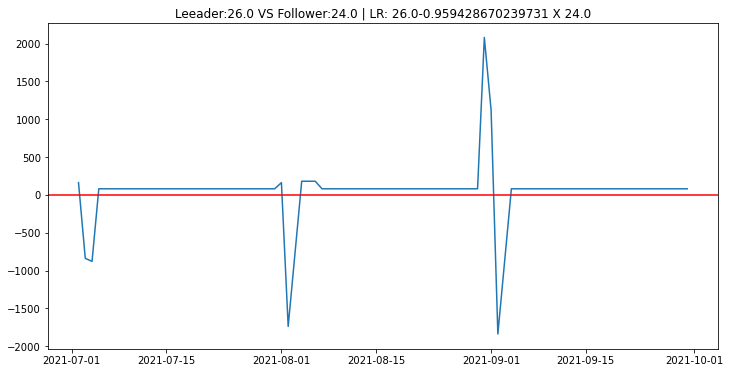

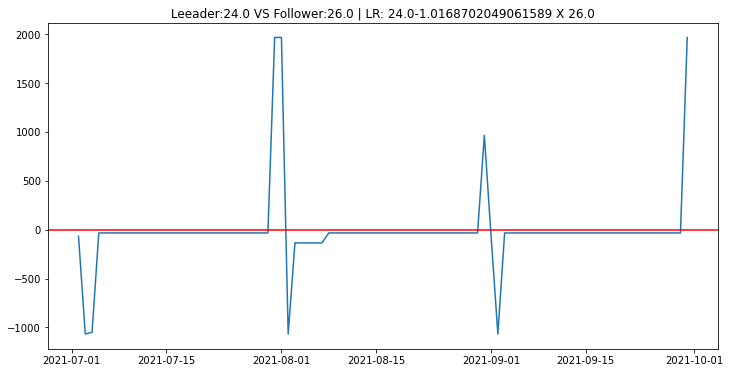

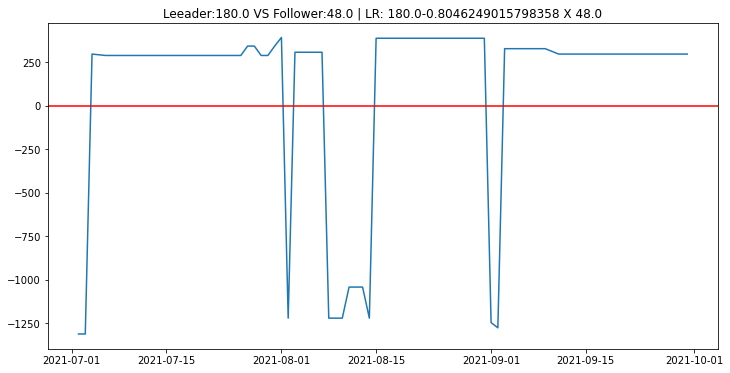

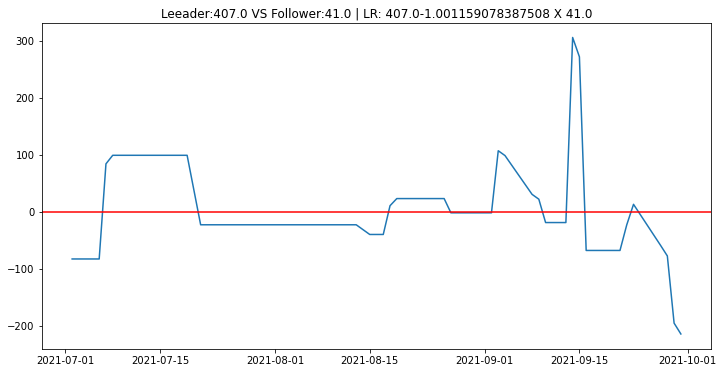

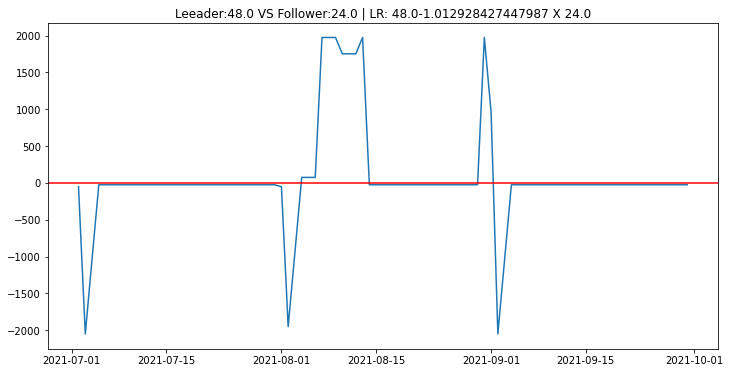

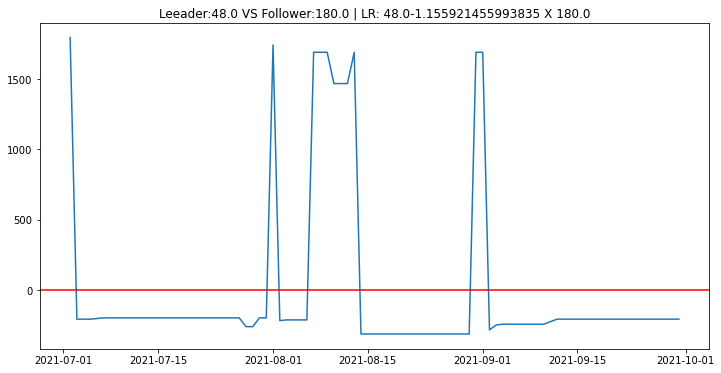

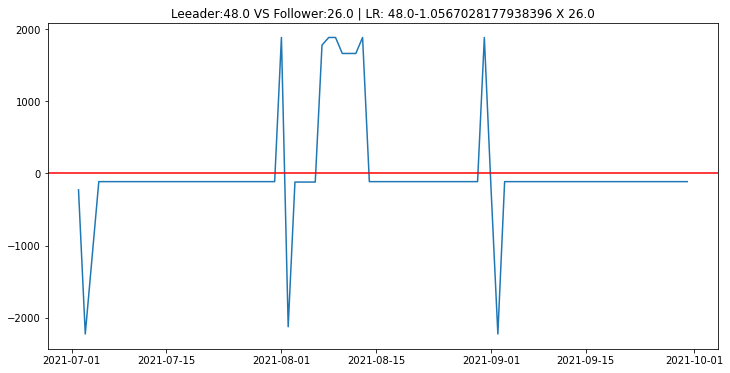

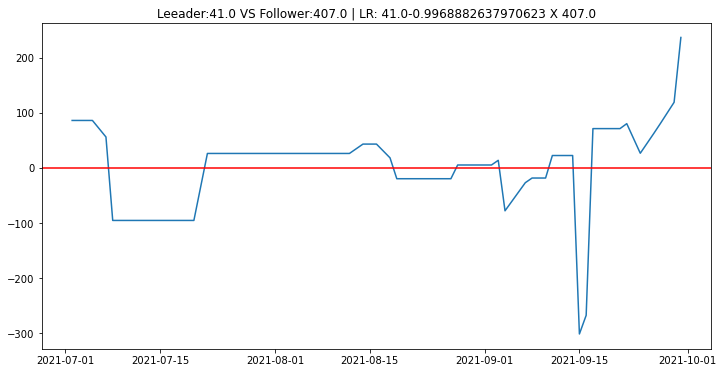

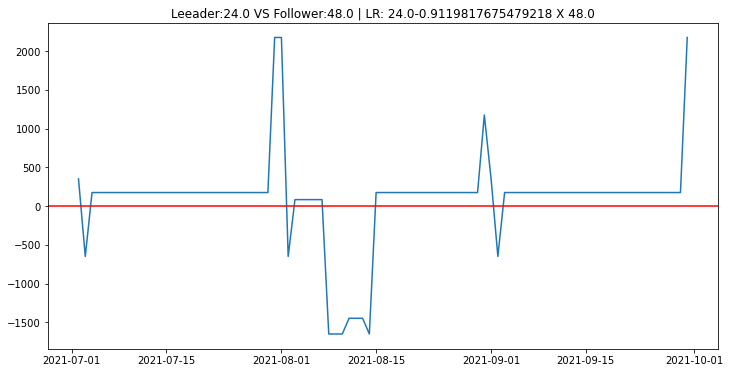

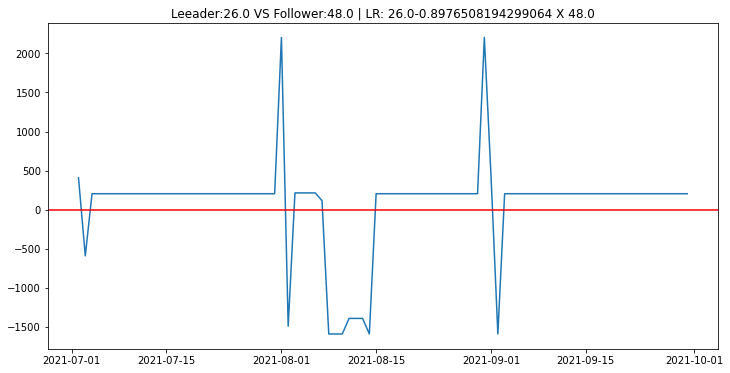

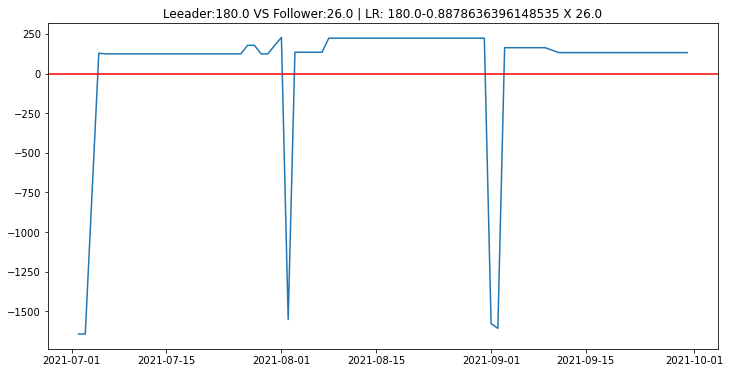

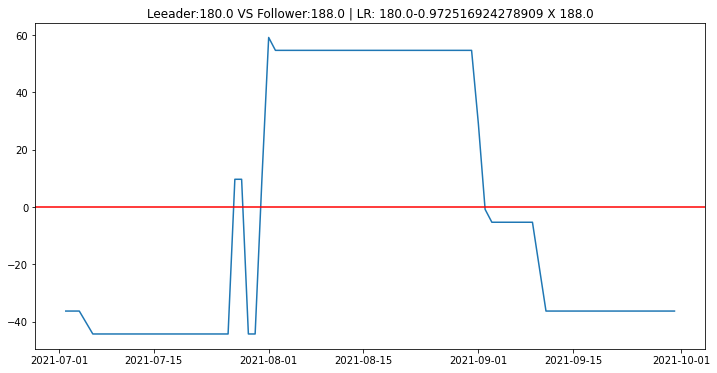

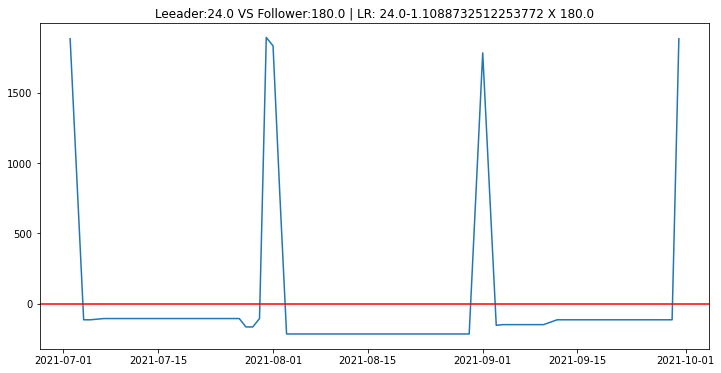

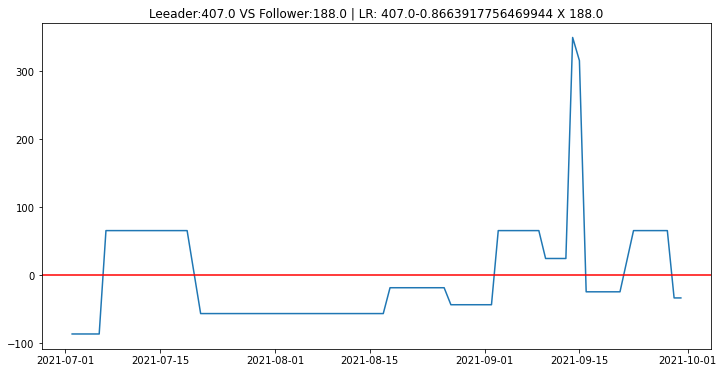

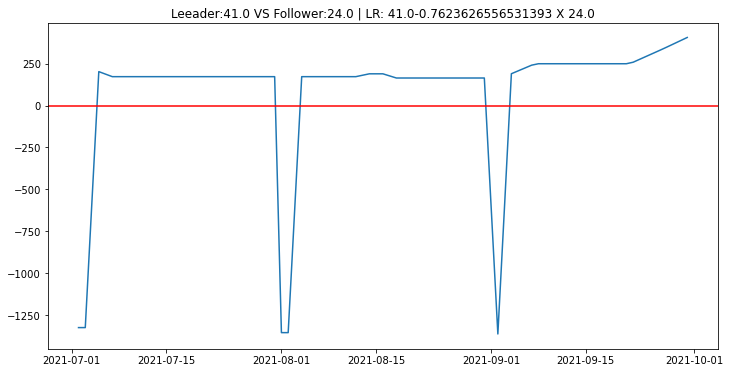

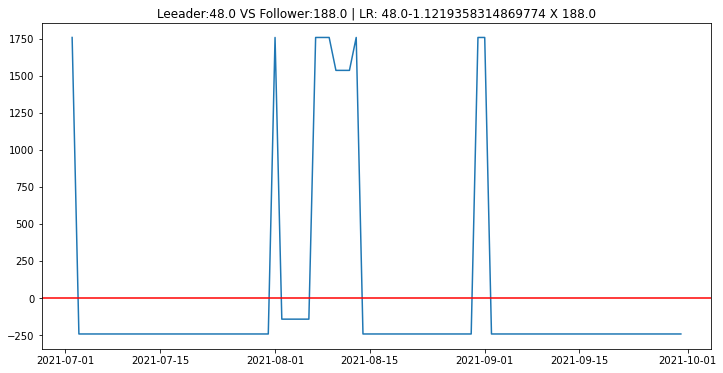

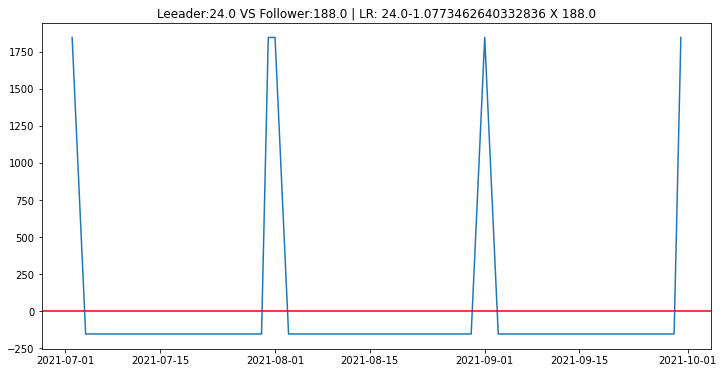

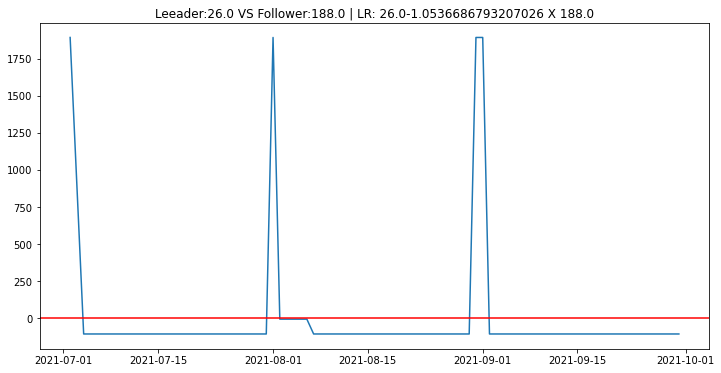

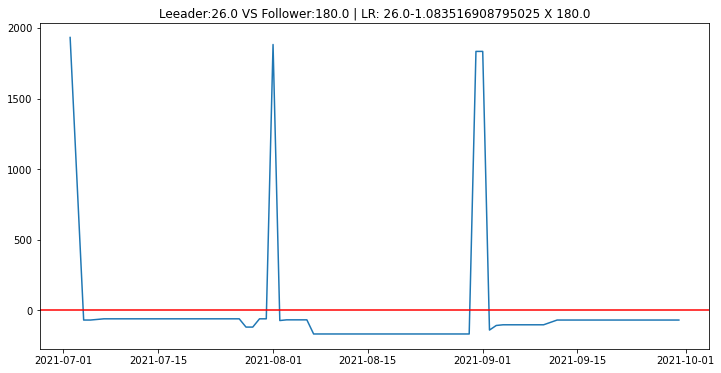

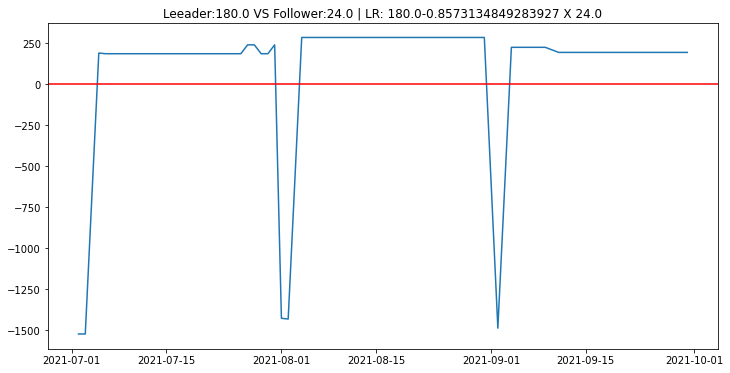

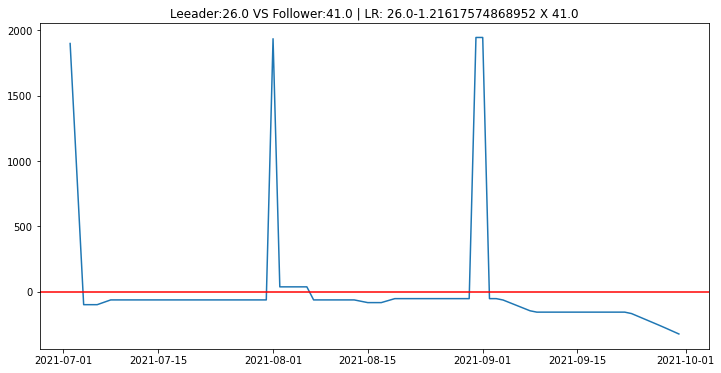

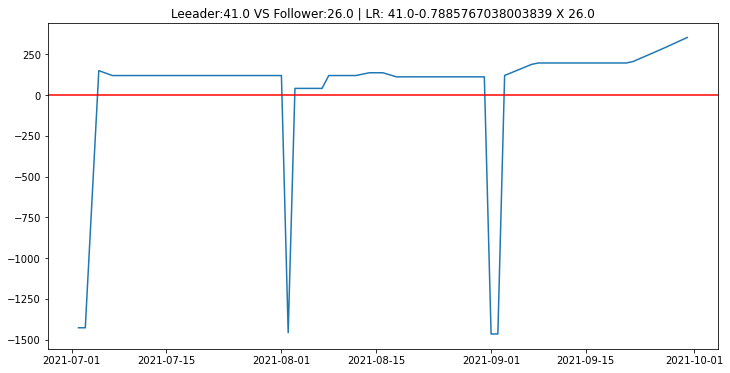

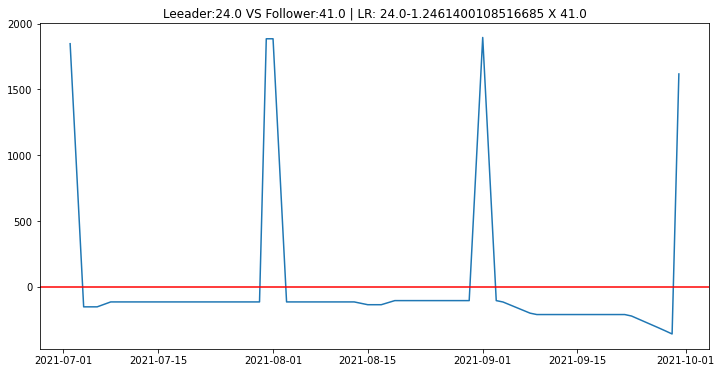

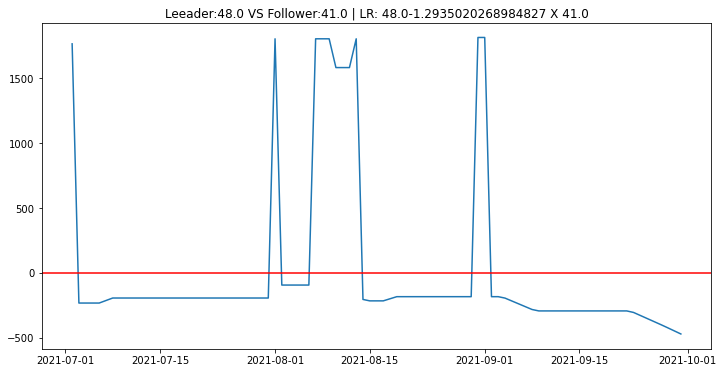

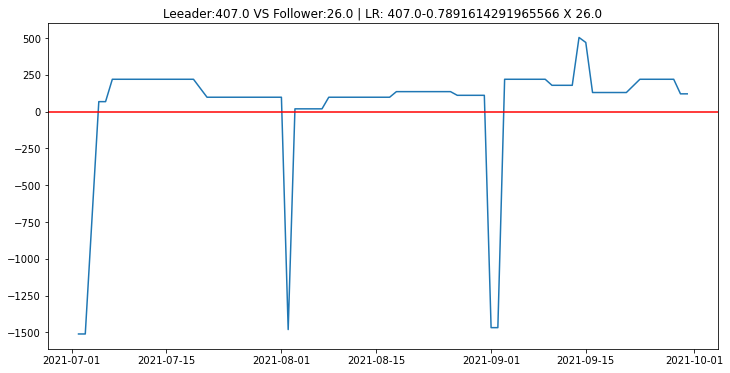

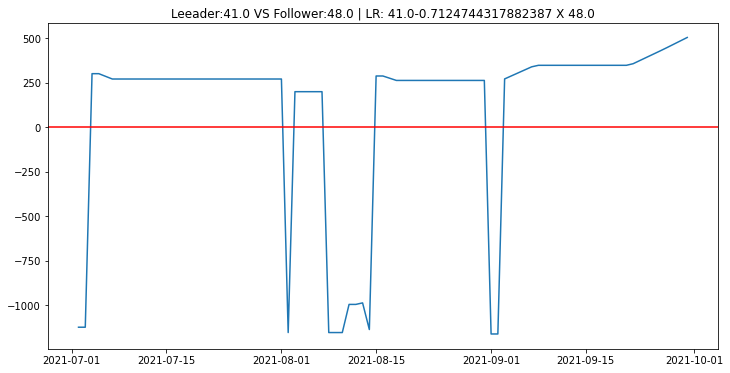

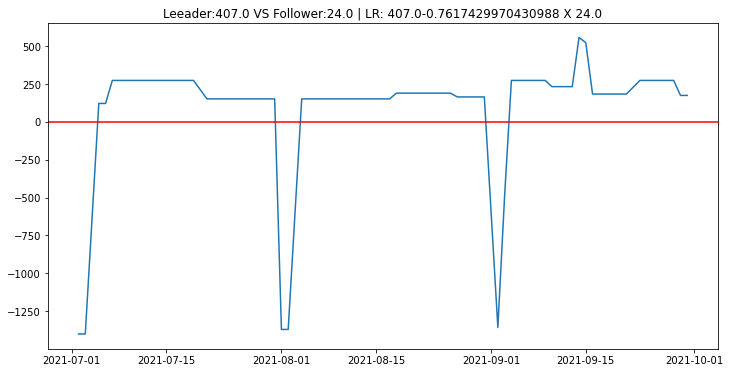

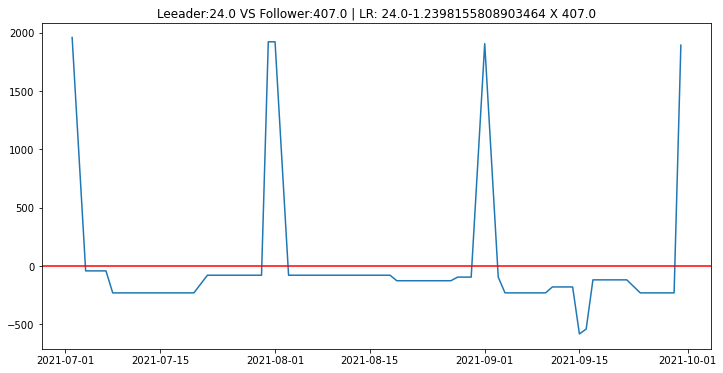

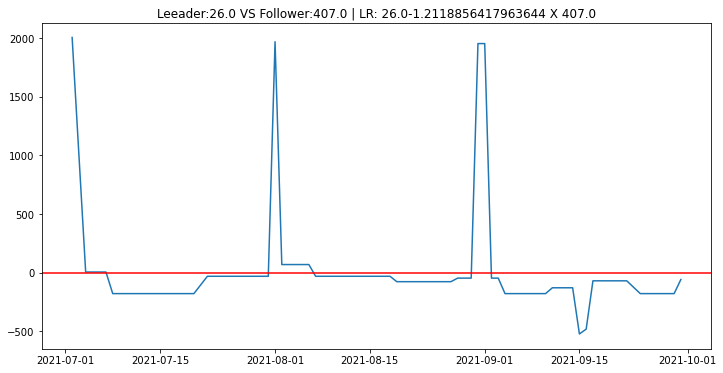

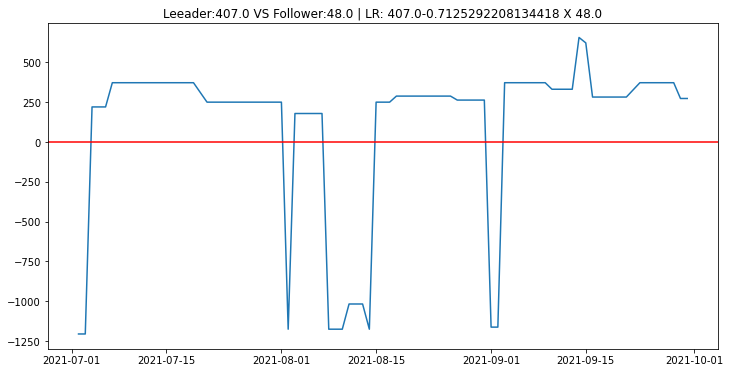

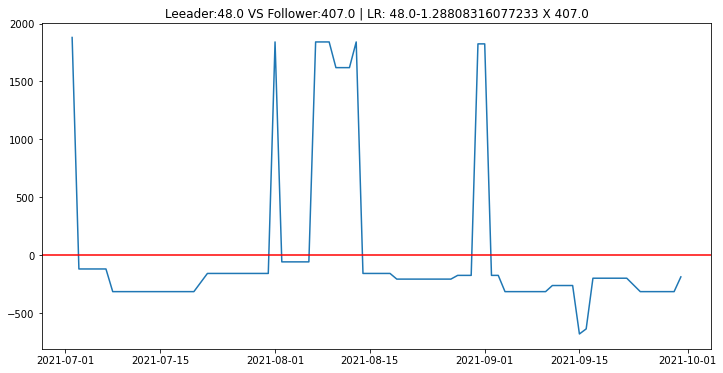

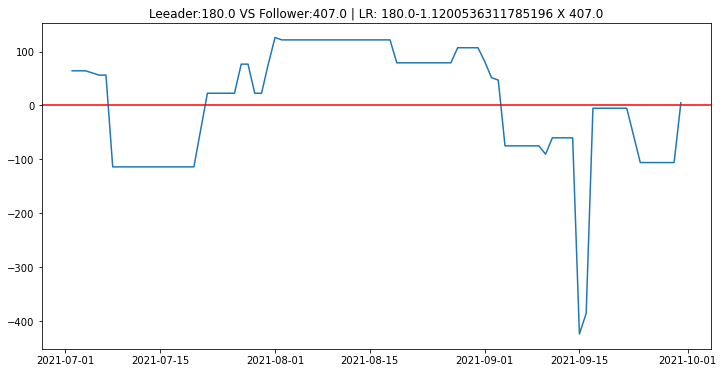

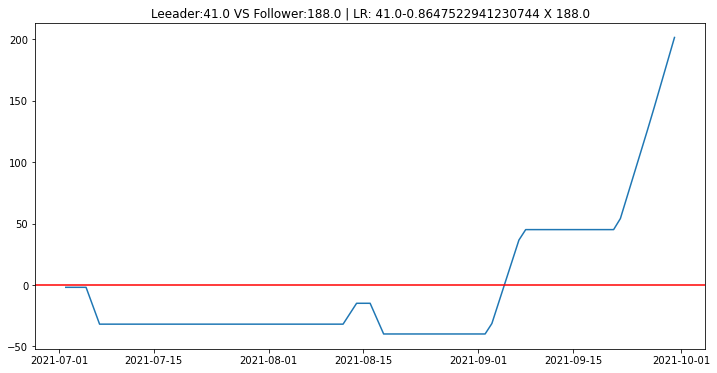

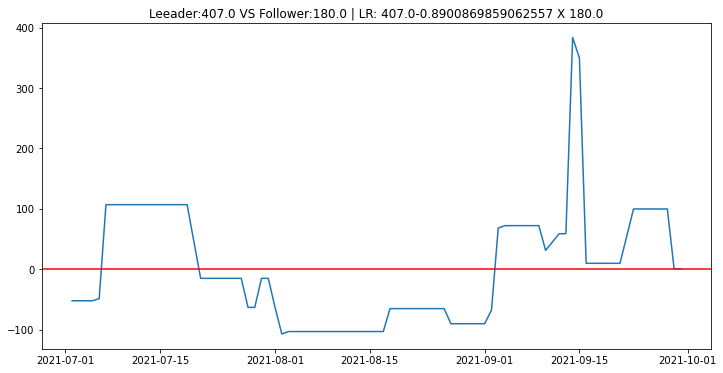

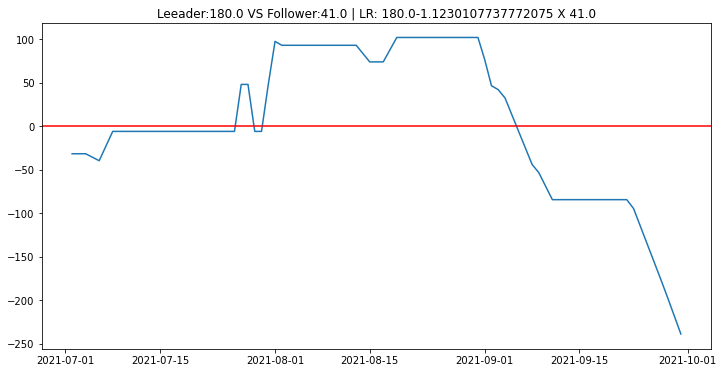

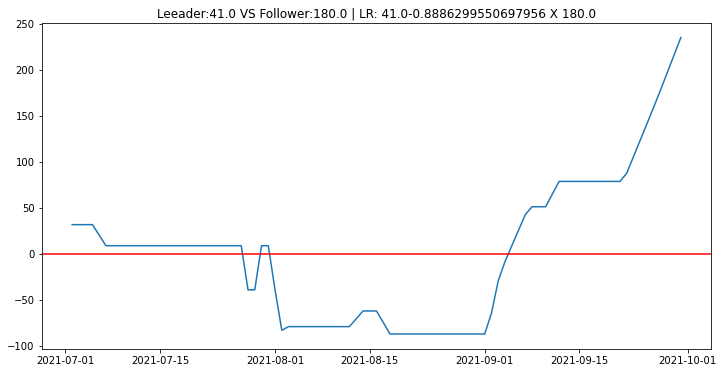

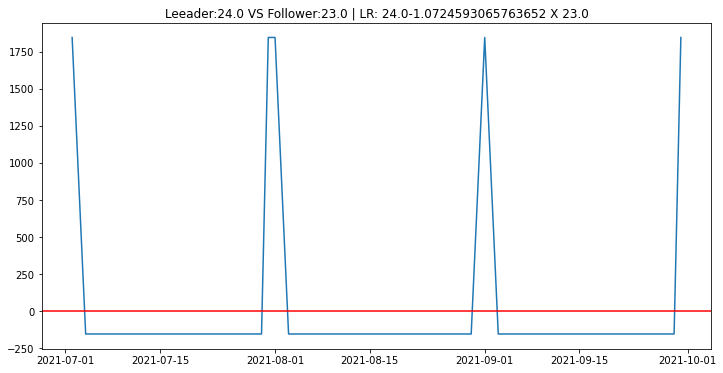

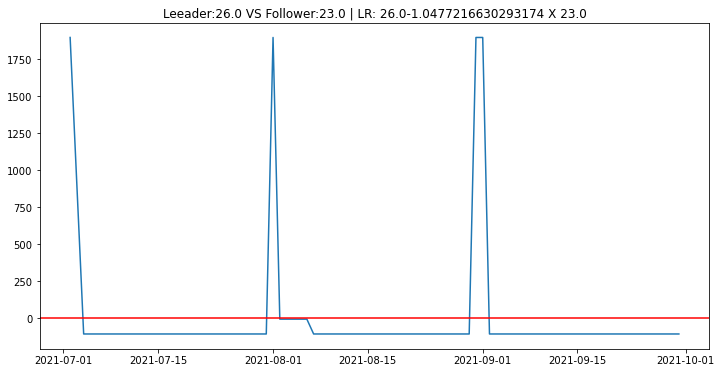

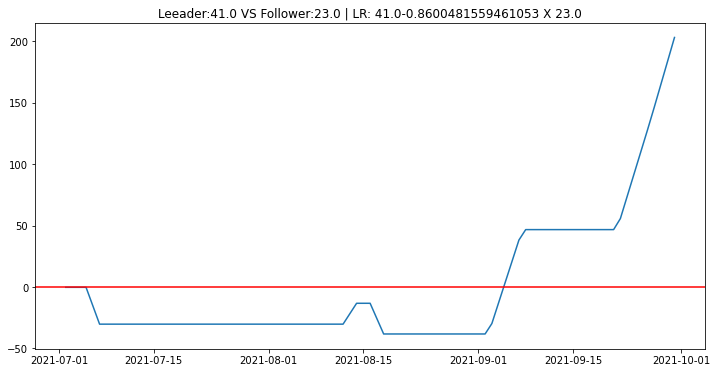

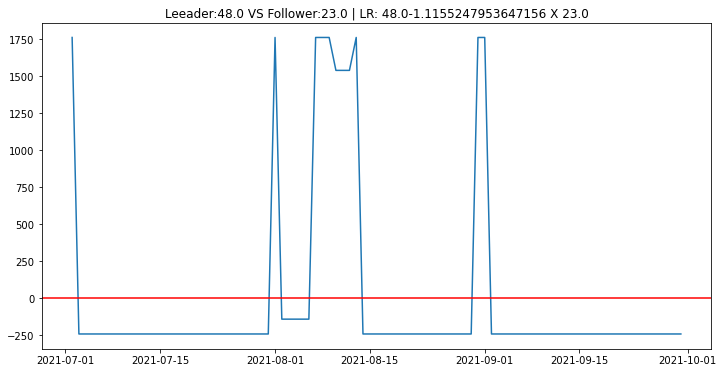

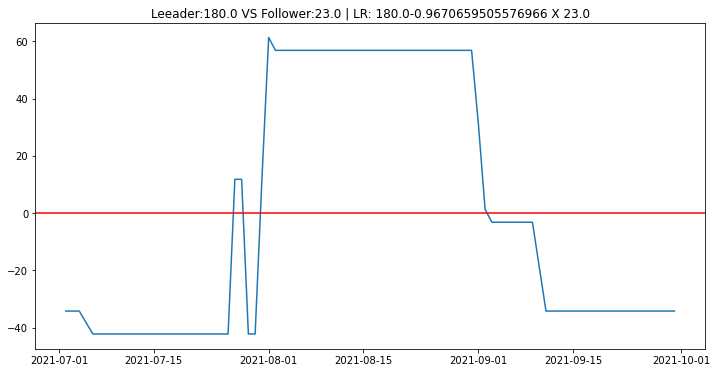

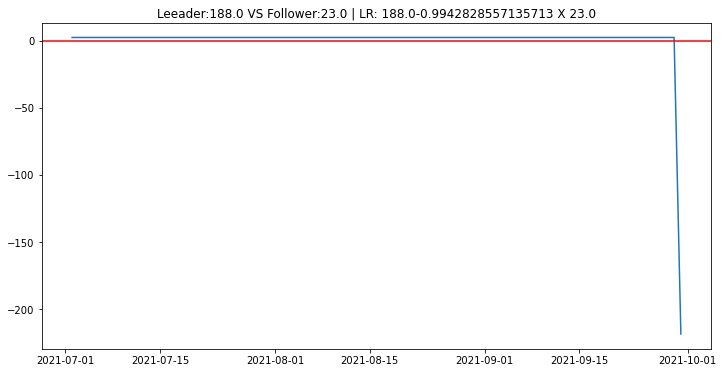

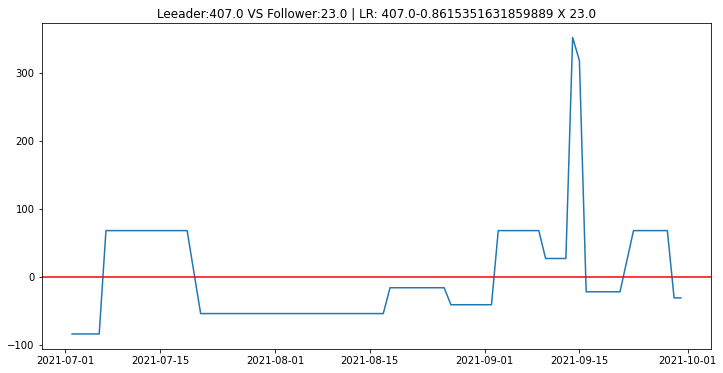

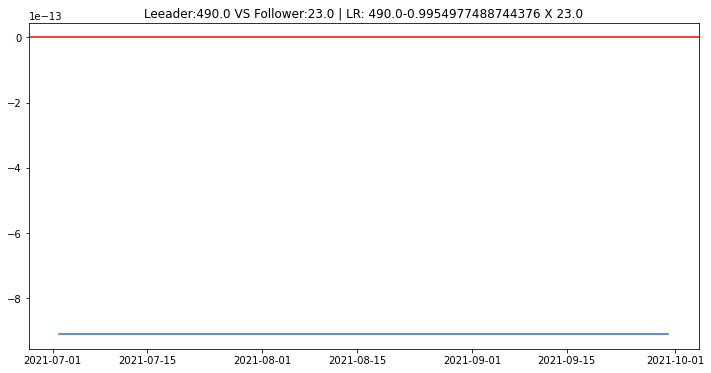

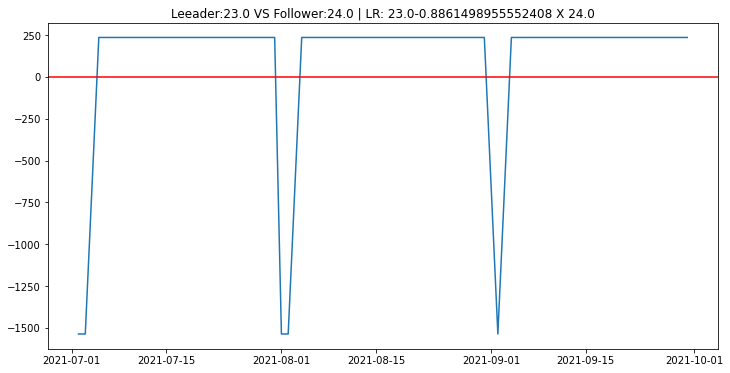

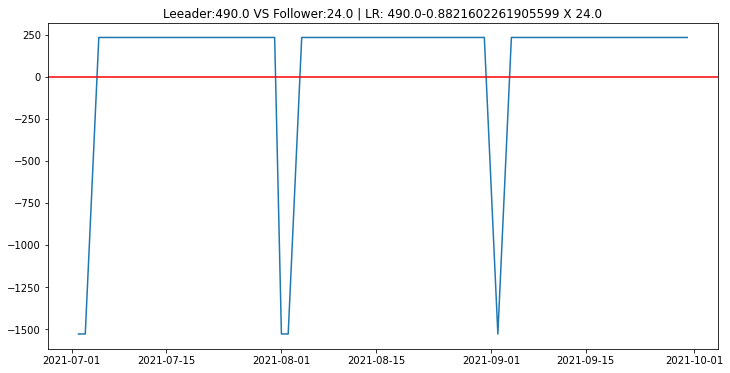

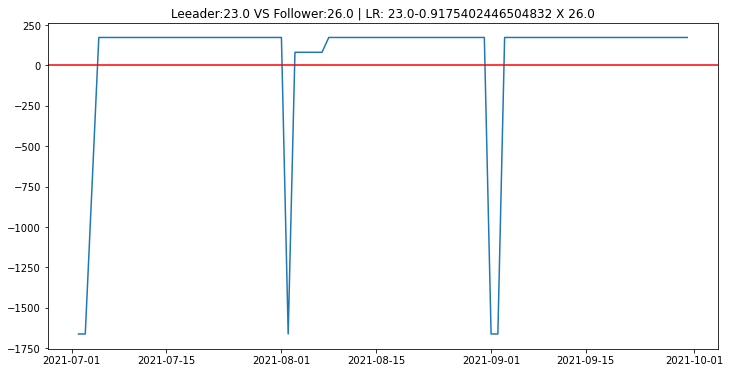

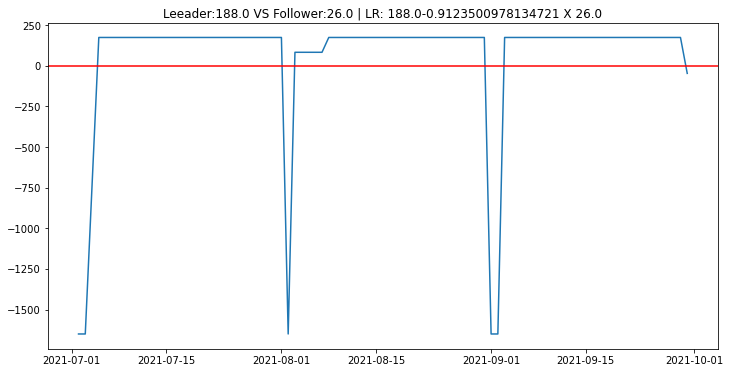

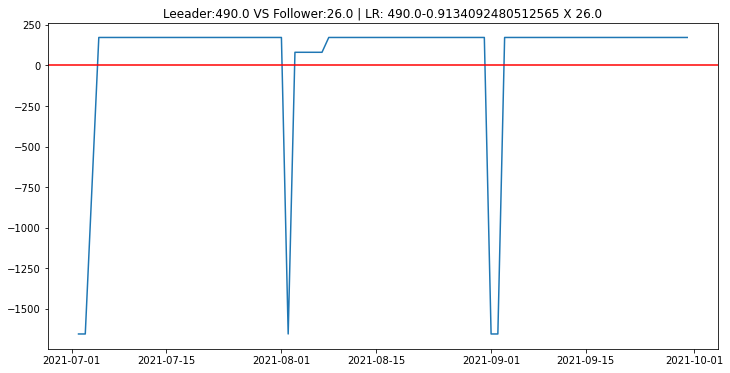

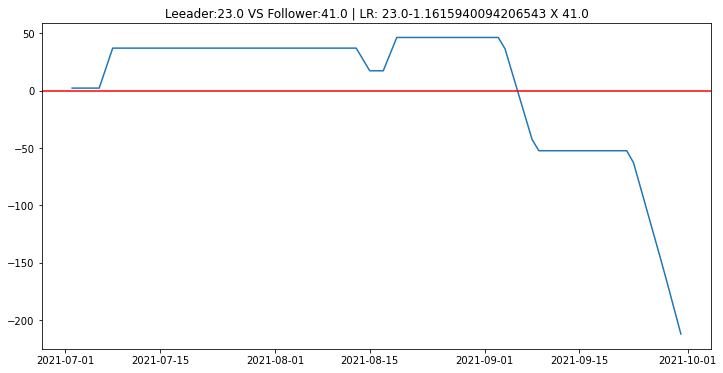

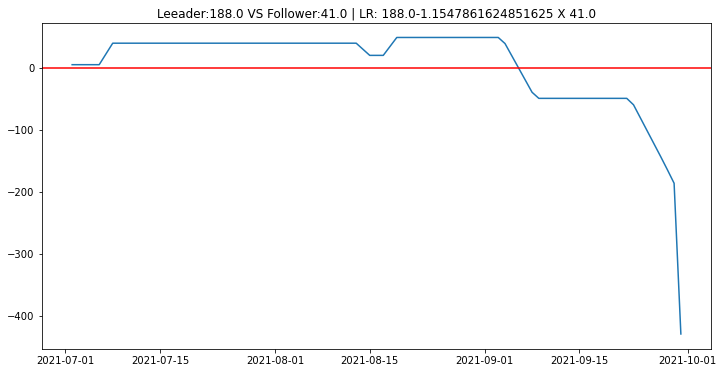

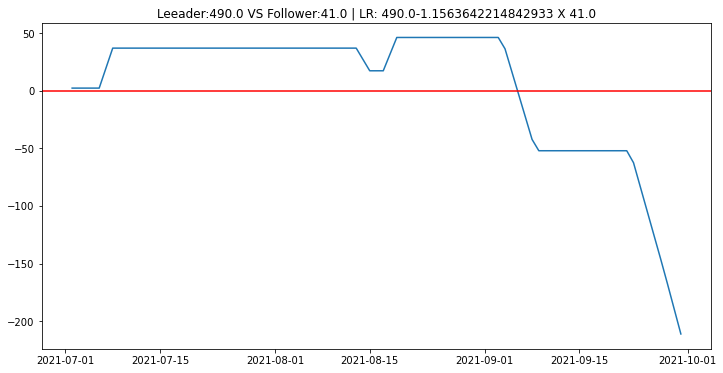

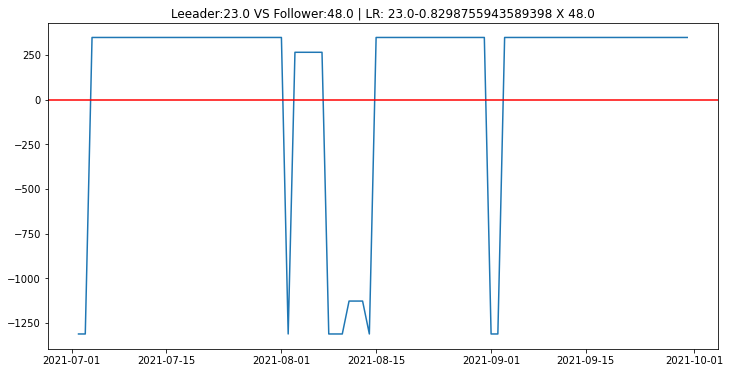

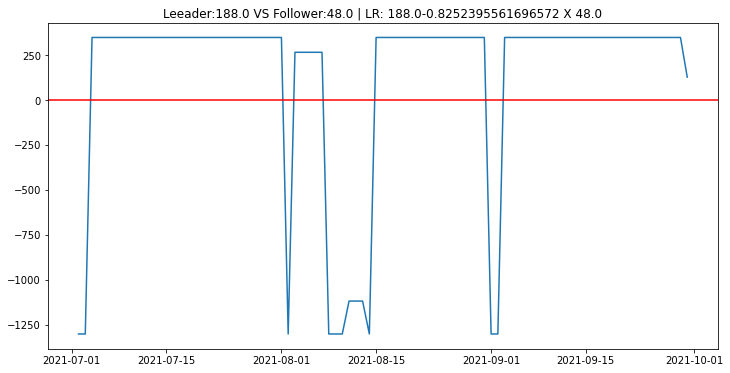

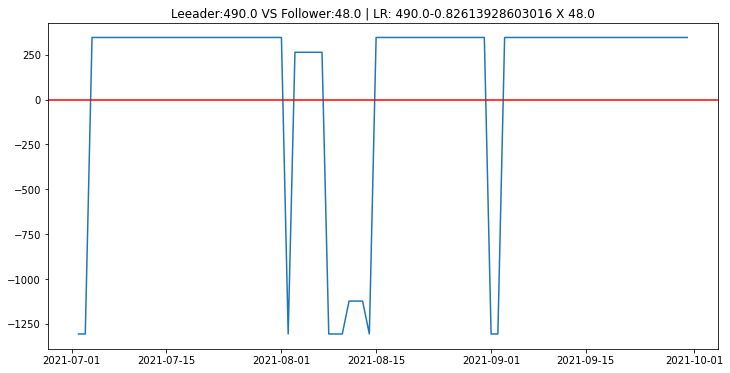

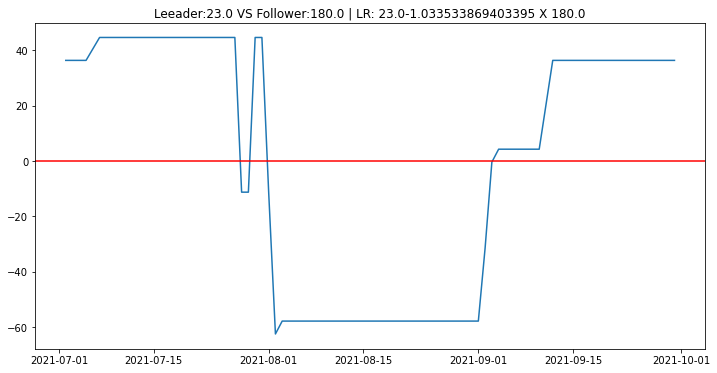

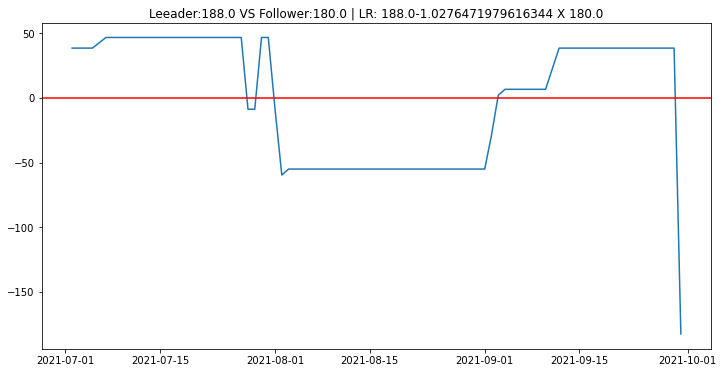

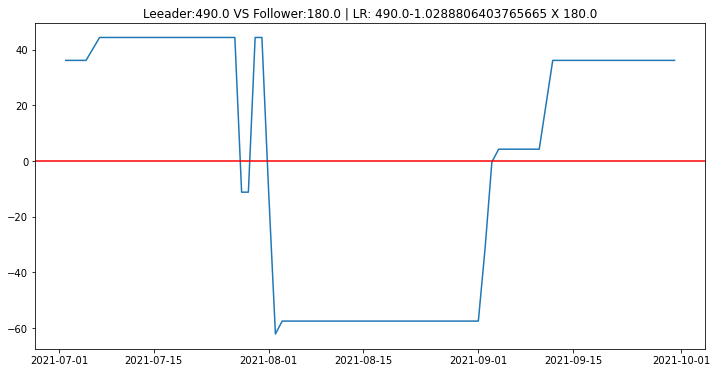

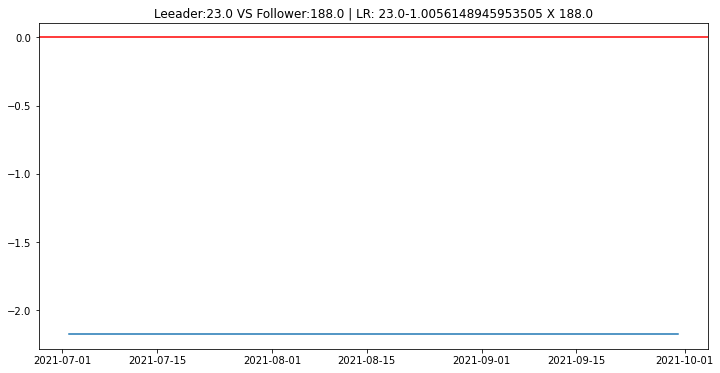

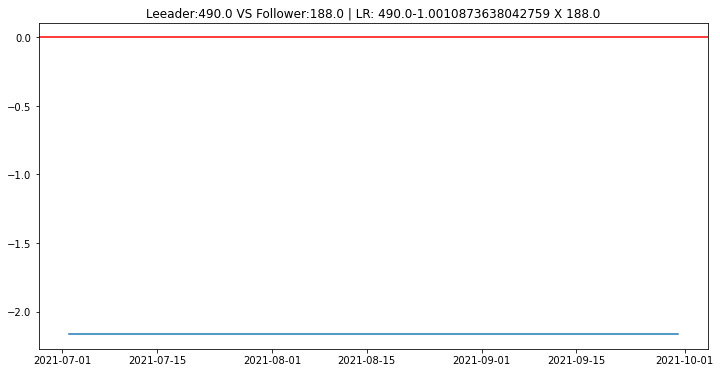

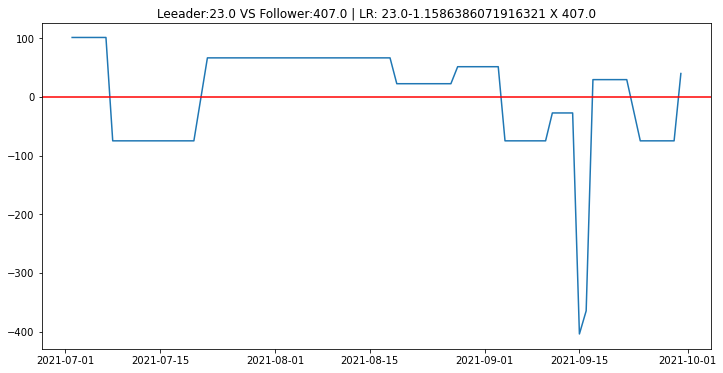

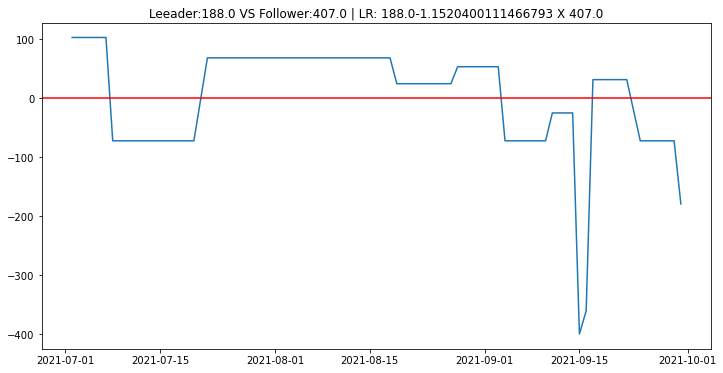

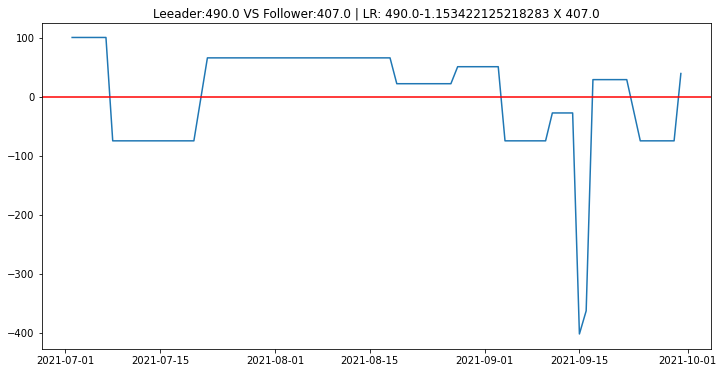

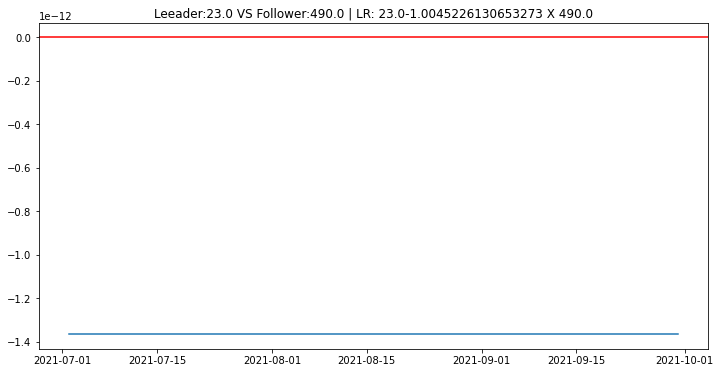

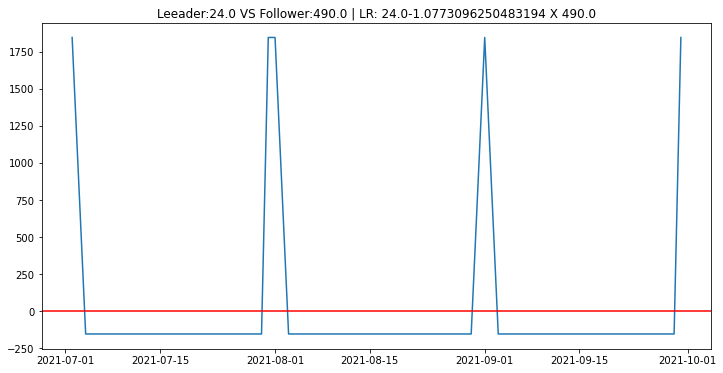

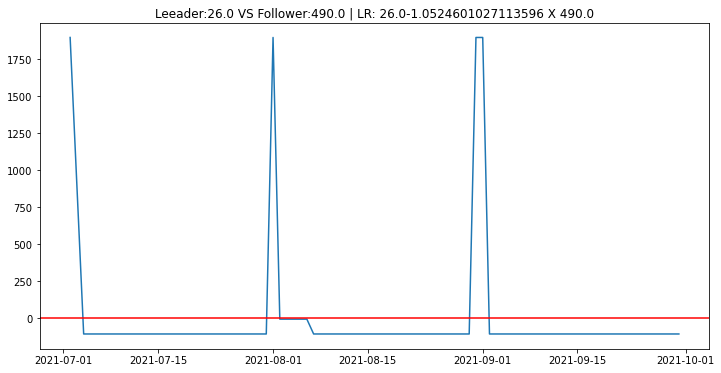

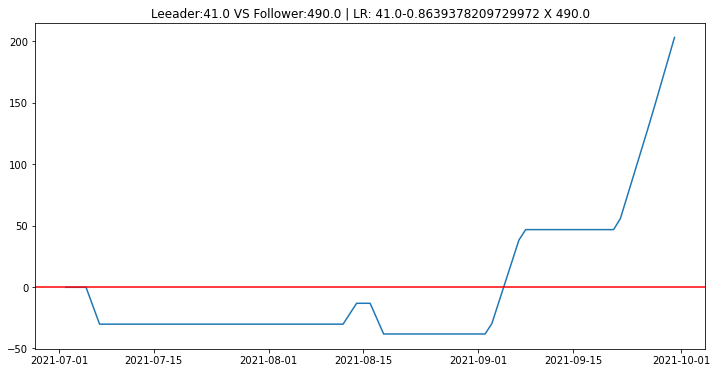

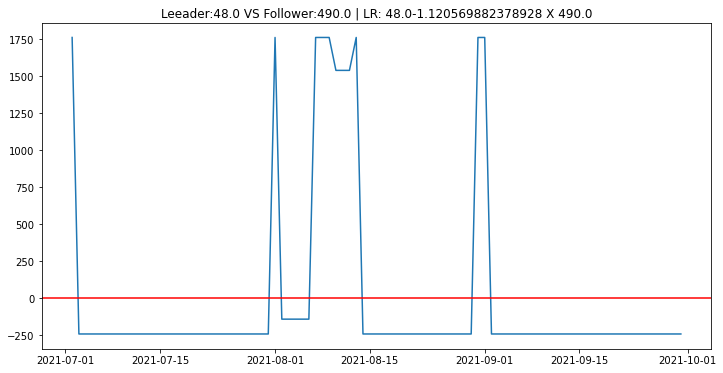

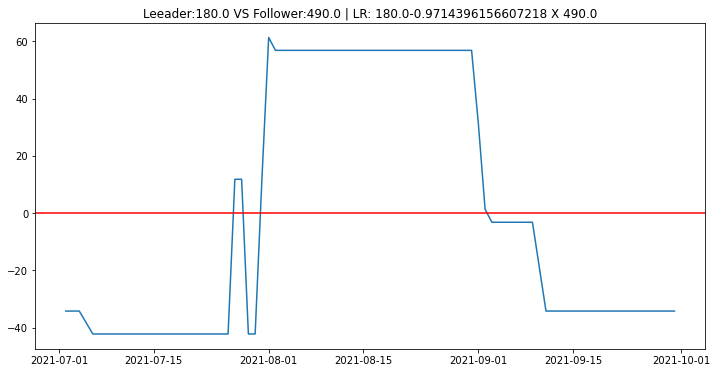

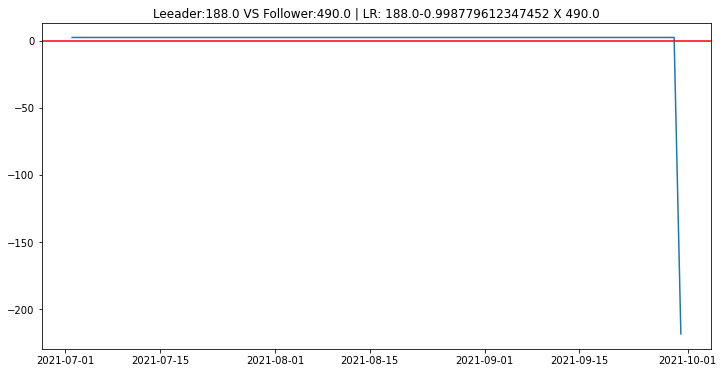

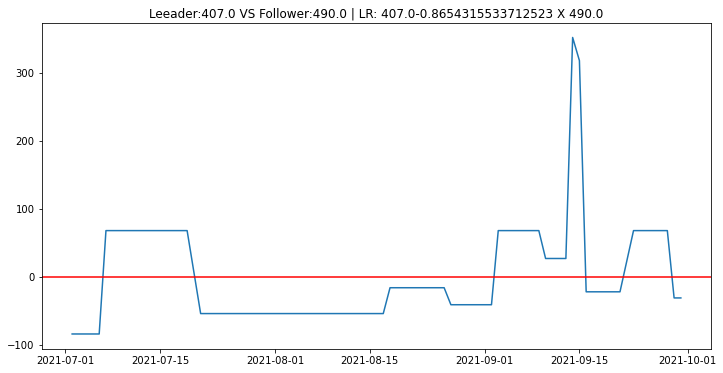

In [38]:
for i in range(sample.shape[0]):
    plt.figure(figsize=(12,6))
    plt.plot(df_final_product[sample.iloc[i]['Leader']] - df_final_product_shift[sample.iloc[i]['Follower']]*sample.iloc[i]['Beta'])
    plt.axhline(y=0.0, color='r', linestyle='-')
    plt.title(str("Leeader:"+str(sample.iloc[i]['Leader']))+" VS Follower:"+  str(sample.iloc[i]['Follower'])+" | LR: "  + str(sample.iloc[i]['Leader'])+"-" + str(sample.iloc[i]['Beta']) + " X " + str(sample.iloc[i]['Follower']))
    plt.show()
    

# Graphs